In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil


from tqdm import tqdm

In [2]:
trainDF = pd.read_csv('./train.csv')
#test = pd.read_csv('./test.csv')


In [3]:
trainDF.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


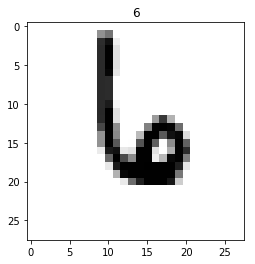

In [5]:
def showImage(df, index):
    #image = df.iloc[index]
    image = trainDF.iloc[index][1:].values.reshape(28,28)
    plt.imshow(image,cmap='Greys')
    plt.title(trainDF['label'].iloc[index])
showImage(trainDF, 123)

In [ ]:
trainDF.groupby('label').count()['pixel0'].plot(x='label',kind = 'bar')
plt.ylabel('count')
plt.xticks(rotation = 'horizontal')
plt.title('Distribution of labels')
plt.show()

In [6]:
#check for nan values 
trainDF.isnull().sum().sum()

0

$\text{The dataset is clean}$

### $\text{Define the function useful in our model}$

# $\textbf{Pytorch}$

In [3]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)


ModuleNotFoundError: No module named 'torch'

### $\underline{\textbf{Model Training}}$

<hr style="height:2px;border:none;color:#333;background-color:#333;"/>